In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

adata = sc.read_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/notebook/xenium.h5ad")

xenium_folder_1 = adata[adata.obs["folder"].eq(adata.obs["folder"].unique()[0])].copy()
xenium_folder_2 = adata[adata.obs["folder"].eq(adata.obs["folder"].unique()[1])].copy()

/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/.venv/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invali

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

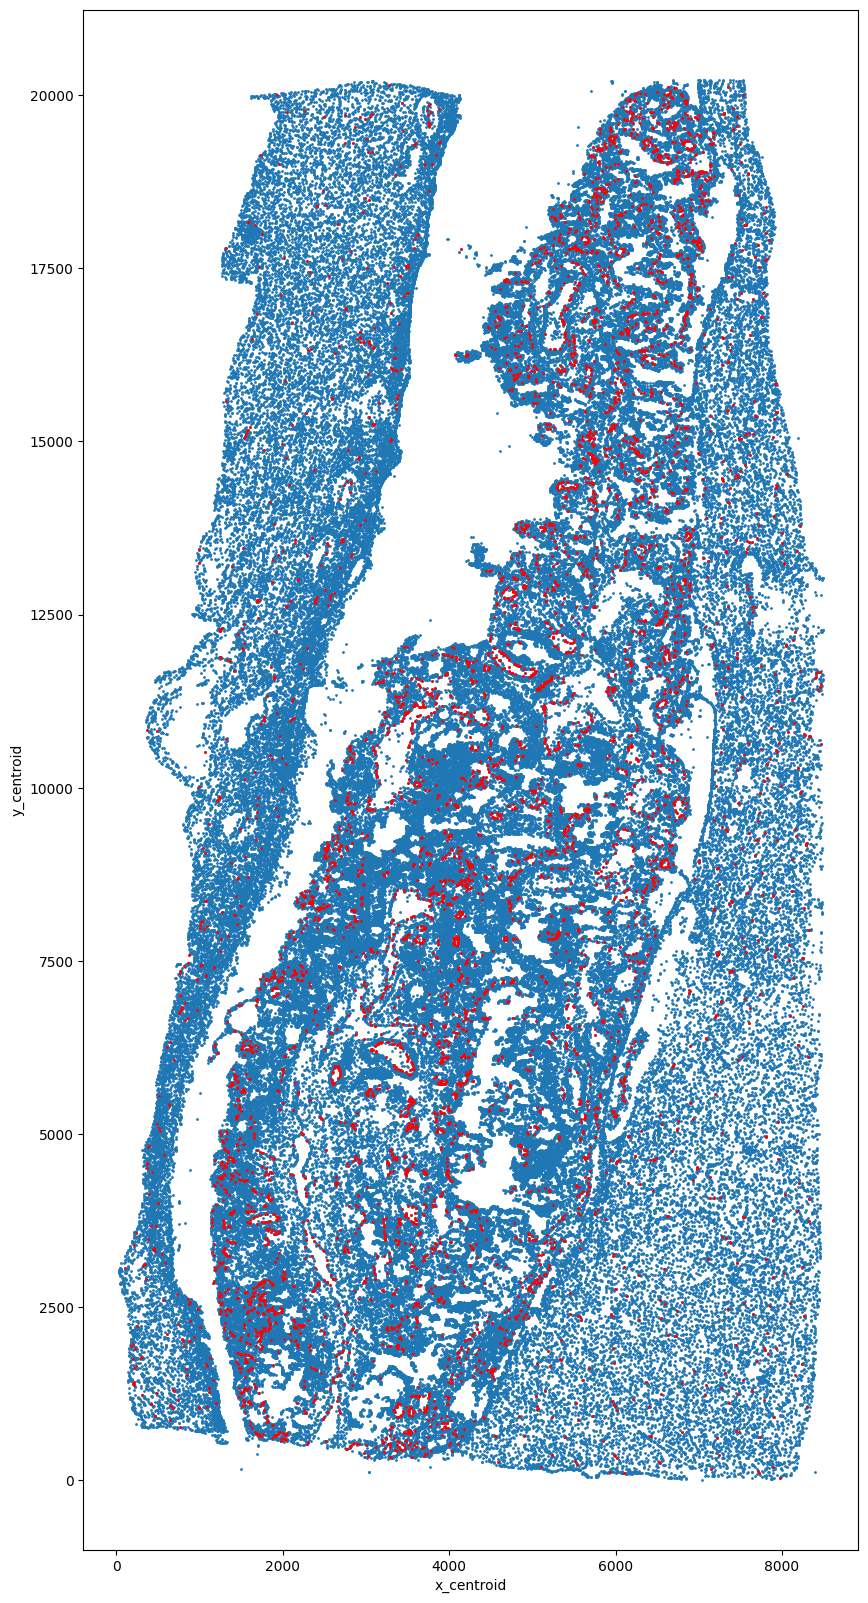

In [11]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 20))
xenium_folder_1.obs.plot.scatter(x="x_centroid", y="y_centroid", ax=ax, s=1)
xenium_folder_1.obs.query("predicted_cell_type == 'Endothelial'").plot.scatter(x="x_centroid", y="y_centroid", c="r", ax=ax, s=1)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

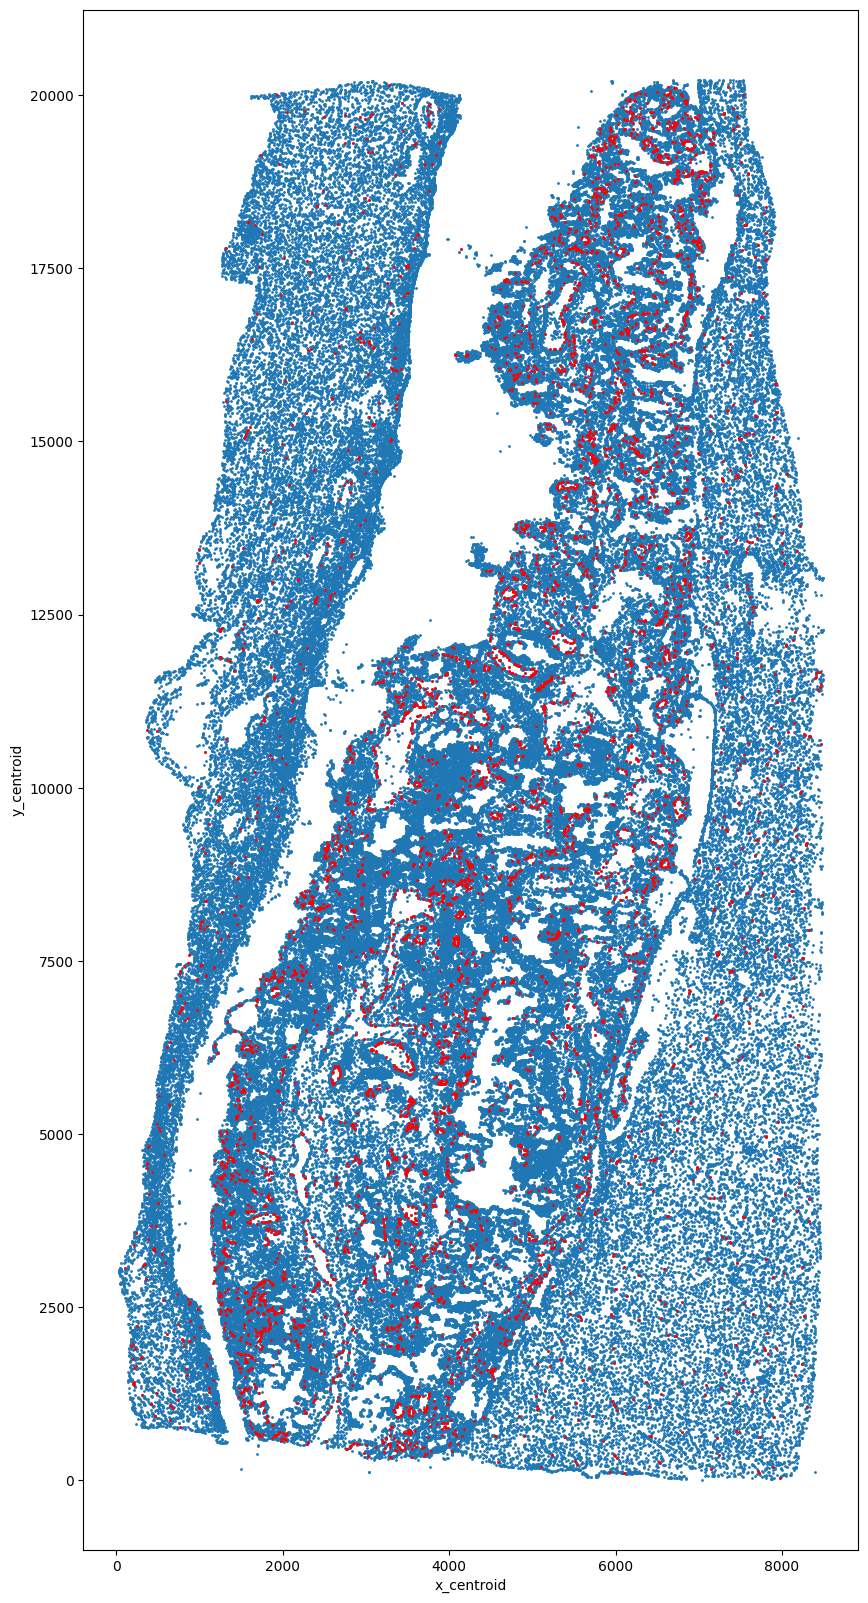

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 20))
xenium_folder_1.obs.plot.scatter(x="x_centroid", y="y_centroid", ax=ax, s=1)
xenium_folder_1.obs.query("predicted_cell_type == 'Endothelial'").plot.scatter(x="x_centroid", y="y_centroid", c="r", ax=ax, s=1)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

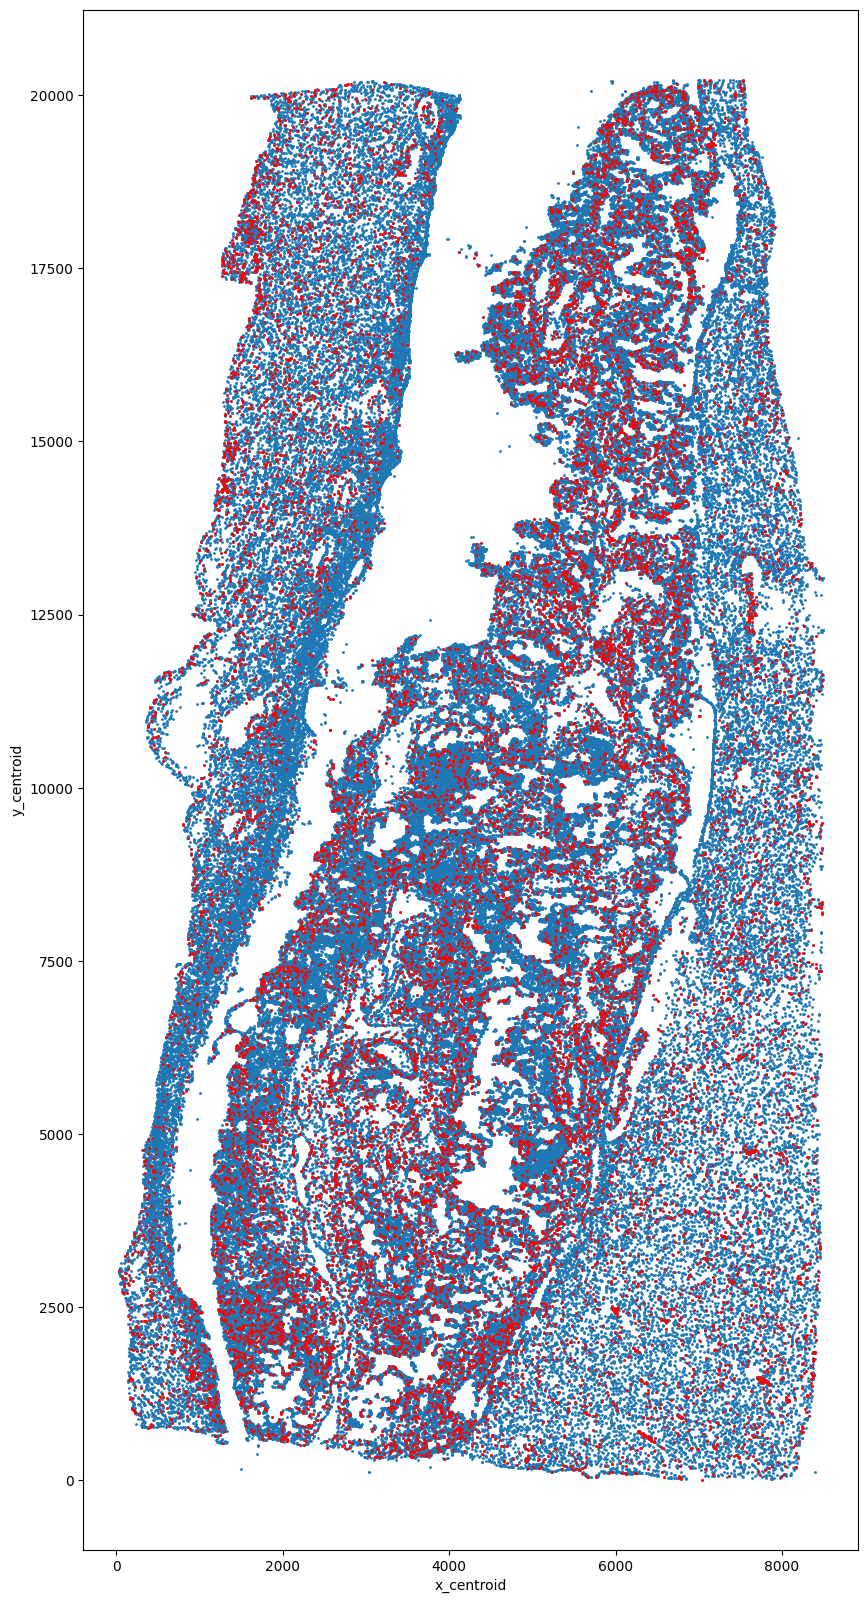

In [15]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 20))
xenium_folder_1.obs.plot.scatter(x="x_centroid", y="y_centroid", ax=ax, s=1)
xenium_folder_1.obs.query("predicted_cell_type == 'Macrophage'").plot.scatter(x="x_centroid", y="y_centroid", c="r", ax=ax, s=1)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

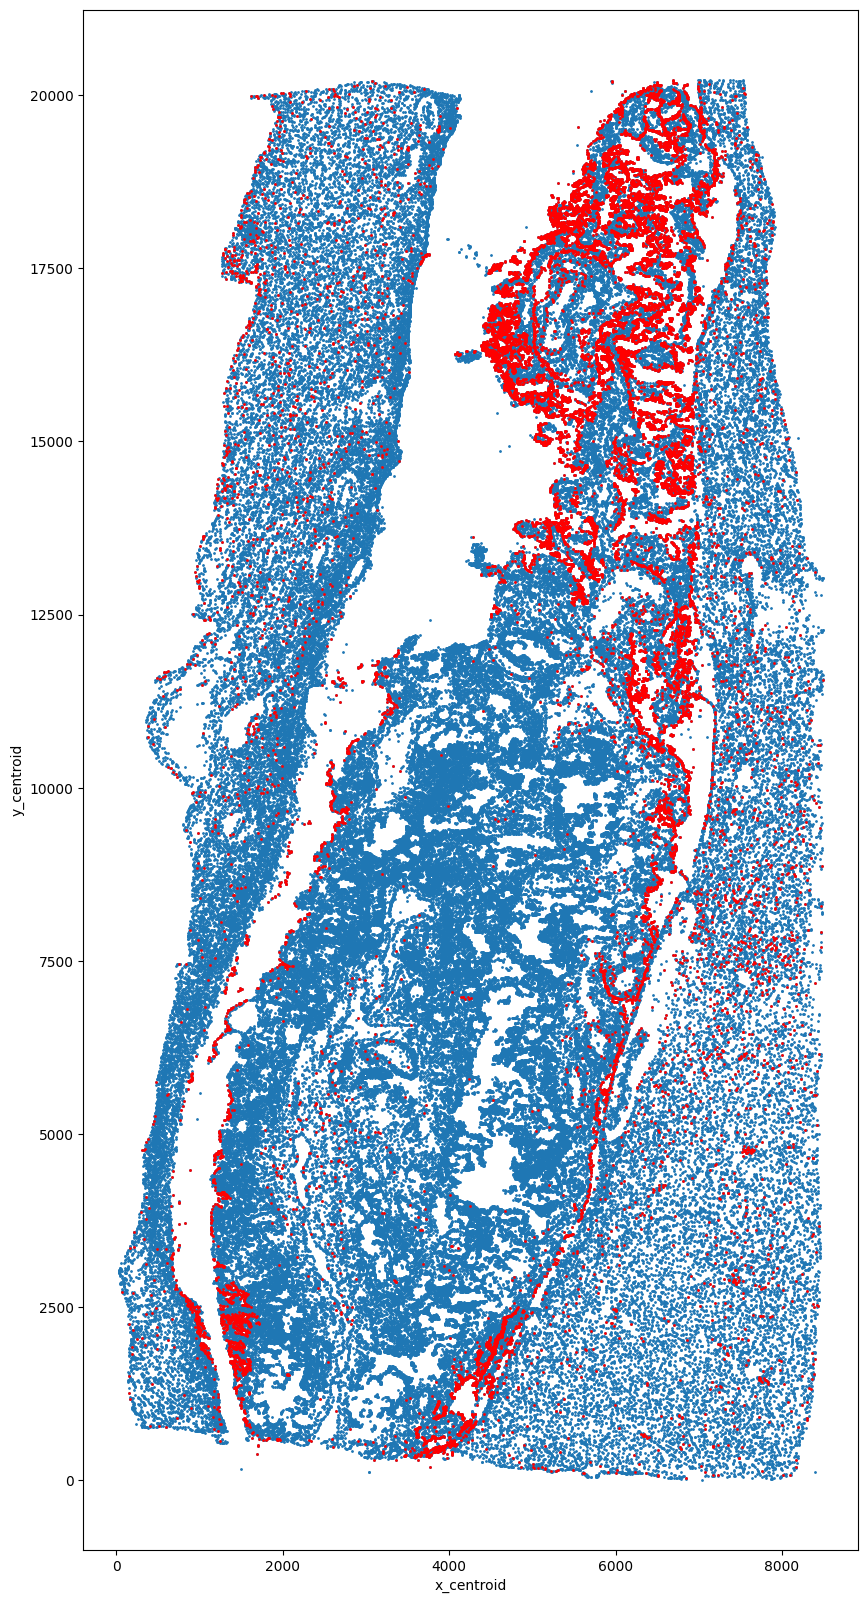

In [12]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 20))
xenium_folder_1.obs.plot.scatter(x="x_centroid", y="y_centroid", ax=ax, s=1)
xenium_folder_1.obs.query("predicted_cell_type == 'Epithelial'").plot.scatter(x="x_centroid", y="y_centroid", c="r", ax=ax, s=1)

In [6]:
distances_tree = cKDTree(xenium_folder_1.obsm["spatial"])
pairs = distances_tree.query_pairs(100)
pairs = pd.DataFrame(pairs).to_numpy().astype(np.int64)

data = xenium_folder_1.X.todense().astype(np.float64)

import os.path as osp

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import (
    completeness_score,
    homogeneity_score,
    v_measure_score,
)
from torch.nn import Linear

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ARGVA, GCNConv

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

from torch_geometric.data import Data
dataset = Data(x=torch.Tensor(data).to(device), edge_index=torch.Tensor(pairs.T).long().to(device), y=torch.Tensor(xenium_folder_1.obs["predicted_cell_type"].cat.codes).long().to(device))
dataset = transform(dataset)
data = dataset[0]

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x).relu()
        return self.lin3(x)


encoder = Encoder(data.num_features, hidden_channels=32, out_channels=32)
discriminator = Discriminator(in_channels=32, hidden_channels=64,
                              out_channels=32)
model = ARGVA(encoder, discriminator).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.001)

/tmp/ipykernel_25110/4223007254.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dataset = Data(x=torch.Tensor(data).to(device), edge_index=torch.Tensor(pairs.T).long().to(device), y=torch.Tensor(xenium_folder_1.obs["predicted_cell_type"].cat.codes).long().to(device))


In [8]:
from tqdm import tqdm

In [ ]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    # We optimize the discriminator more frequently than the encoder.
    for i in range(5):
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z)
        discriminator_loss.backward()
        discriminator_optimizer.step()

    loss = model.recon_loss(z, data.pos_edge_label_index)
    loss = loss + model.reg_loss(z)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    encoder_optimizer.step()
    return float(loss)


for epoch in tqdm(range(1, 10000)):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss {loss}')

# torch.save(model, "argva_1000.pt")

In [9]:
import torch
model = torch.load("/oak/stanford/projects/kibr/Reorganizing/Projects/choroid-plexus/notebook/argva_1000.pt")

/tmp/ipykernel_25110/2138265654.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/oak/stanford/projects/kibr/Reorganizing/Projects/choroid-plexus/note

In [10]:
xenium_folder_1.obsm["X_ARGVA"] = model.encode(data.x, data.edge_index).detach().numpy()

In [11]:
sc.pp.neighbors(xenium_folder_1, use_rep="X_ARGVA")
sc.tl.umap(xenium_folder_1)

In [31]:
xenium_folder_1 = sc.read_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/data/processed/8_spatial_niches.h5ad")
adata = xenium_folder_1

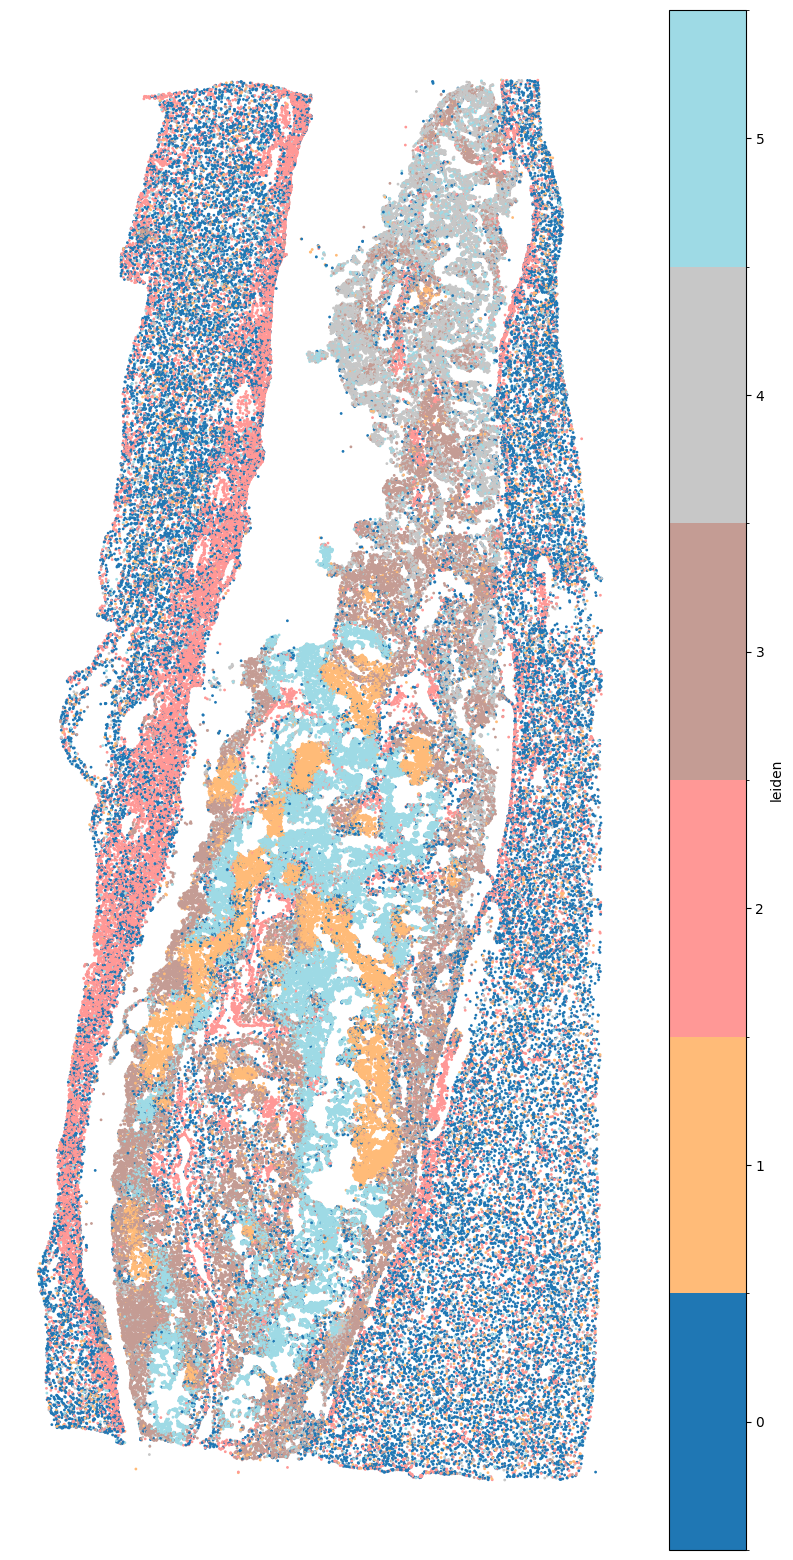

In [33]:
f, ax = plt.subplots()
adata.obs.plot.scatter(x="x_centroid", y="y_centroid", c="leiden", cmap = "tab20", figsize=(10, 20), s=1, ax = ax)

# Sugar
ax.xaxis.set_visible(False)  # Hide x-axis
ax.yaxis.set_visible(False)  # Hide y-axis

for spine in ax.spines.values():
    spine.set_visible(False)

In [34]:
coords = adata.obsm[["x_centroid", "y_centroid"]].to_numpy()[adata.obs["leiden"].eq(cell_type)]

TypeError: unhashable type: 'list'

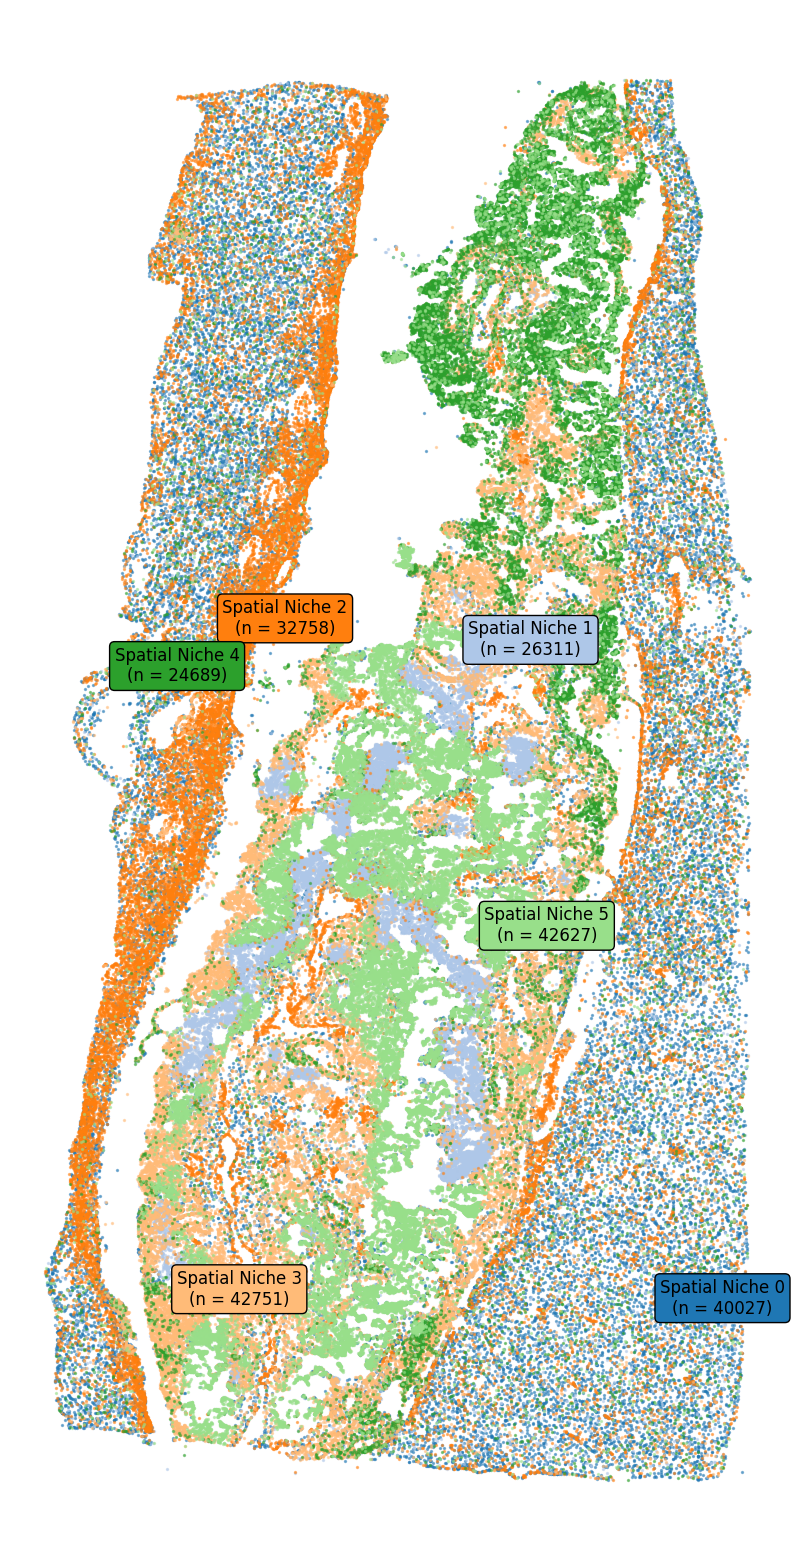

In [83]:
import adjustText
f, ax = plt.subplots(figsize=(10, 20))

cell_type_colors = {
    "0": '#1f77b4',
    "1": '#aec7e8',
    "2": '#ff7f0e',
    "3": '#ffbb78',
    "4": '#2ca02c',
    "5": '#98df8a',
}

texts = []
for cell_type in sorted(adata.obs["leiden"].unique()):
    coords = adata.obs[["x_centroid", "y_centroid"]].to_numpy()[adata.obs["leiden"].eq(cell_type)]
    ax.scatter(coords[:, 0], coords[:, 1], color=cell_type_colors[cell_type], s=2, alpha=0.5)

    x, y = adata.obs[["x_centroid", "y_centroid"]][adata.obs["leiden"].eq(cell_type)].sample(1).iloc[0].tolist()


    texts.append(plt.text(x, y, s=f"Spatial Niche {cell_type}\n(n = {coords.shape[0]})", bbox=dict(facecolor=cell_type_colors[cell_type], edgecolor='black', boxstyle='round'), fontsize=12))

adjustText.adjust_text(texts,  arrowprops=dict(arrowstyle="-", color='r'))


# Sugar
ax.xaxis.set_visible(False)  # Hide x-axis
ax.yaxis.set_visible(False)  # Hide y-axis

for spine in ax.spines.values():
    spine.set_visible(False)

plt.savefig("choroid-plexus-spatial.pdf")

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from matplotlib.colors import ListedColormap

def interpolate_coordinates(start_coords, end_coords, num_frames=50):
    """
    Interpolate between two sets of coordinates.

    Parameters:
    - start_coords: numpy array of shape (n_points, 2) for the starting coordinates.
    - end_coords: numpy array of shape (n_points, 2) for the ending coordinates.
    - num_frames: number of frames for interpolation.

    Returns:
    - frames: list of numpy arrays representing the interpolated coordinates at each frame.
    """
    frames = []
    for t in np.linspace(0, 1, num_frames):
        interpolated_coords = start_coords + t * (end_coords - start_coords)
        frames.append(interpolated_coords)
    return frames

def create_gif(adata, start_coords, end_coords, num_frames=50, gif_path="output.gif"):
    """
    Create a GIF showing the interpolation between two sets of coordinates.

    Parameters:
    - adata: AnnData object containing the data.
    - start_coords: numpy array of shape (n_points, 2) for the starting coordinates.
    - end_coords: numpy array of shape (n_points, 2) for the ending coordinates.
    - num_frames: number of frames for interpolation.
    - gif_path: path to save the output GIF.
    """
    # Map categorical values to numeric codes
    cell_types = adata.obs["predicted_cell_type"].astype("category")
    cell_type_codes = cell_types.cat.codes

    # Interpolate coordinates
    frames = interpolate_coordinates(start_coords, end_coords, num_frames)

    # Create a GIF
    images = []
    for frame in frames:
        plt.figure(figsize=(7, 10))
        plt.scatter(frame[:, 0], frame[:, 1], c=cell_type_codes, cmap="tab20", s=1)
        plt.title("Interpolated Coordinates")
        plt.axis("off")

        # Save the plot to a temporary image
        plt.savefig("temp_frame.png", bbox_inches="tight", pad_inches=0)
        plt.close()

        # Read the image and append to the list
        images.append(imageio.imread("temp_frame.png"))

    # Save the list of images as a GIF
    imageio.mimsave(gif_path, images, duration=10)

start_coords = adata.obs[["x_centroid", "y_centroid"]].to_numpy()  # Your starting coordinates
end_coords = adata.obsm["X_umap"]    # Your ending coordinates
create_gif(adata, start_coords, end_coords, num_frames=200, gif_path="output.gif")

/tmp/ipykernel_25110/3686281304.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("temp_frame.png"))


In [37]:
adata.obs["predicted_cell_type"] = adata.obs["predicted_cell_type"].replace({
    "Inhibitory Neuron": "Neuron",
    "Interneuron": "Neuron",
    "Neural": "Neuron",
    "Astro": "Astrocyte",
    "Fib-1": "Fibroblast - 1",
    "Fib-2": "Fibroblast - 2",
    "Fib-3": "Fibroblast - 3",
    "Fib-4": "Fibroblast - 4",
    "Oligo": "Oligodendrocyte",
})

/tmp/ipykernel_25110/1562481354.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["predicted_cell_type"] = adata.obs["predicted_cell_type"].replace({


/tmp/ipykernel_25110/2050867311.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts = xenium_folder_1.obs.pivot_table(


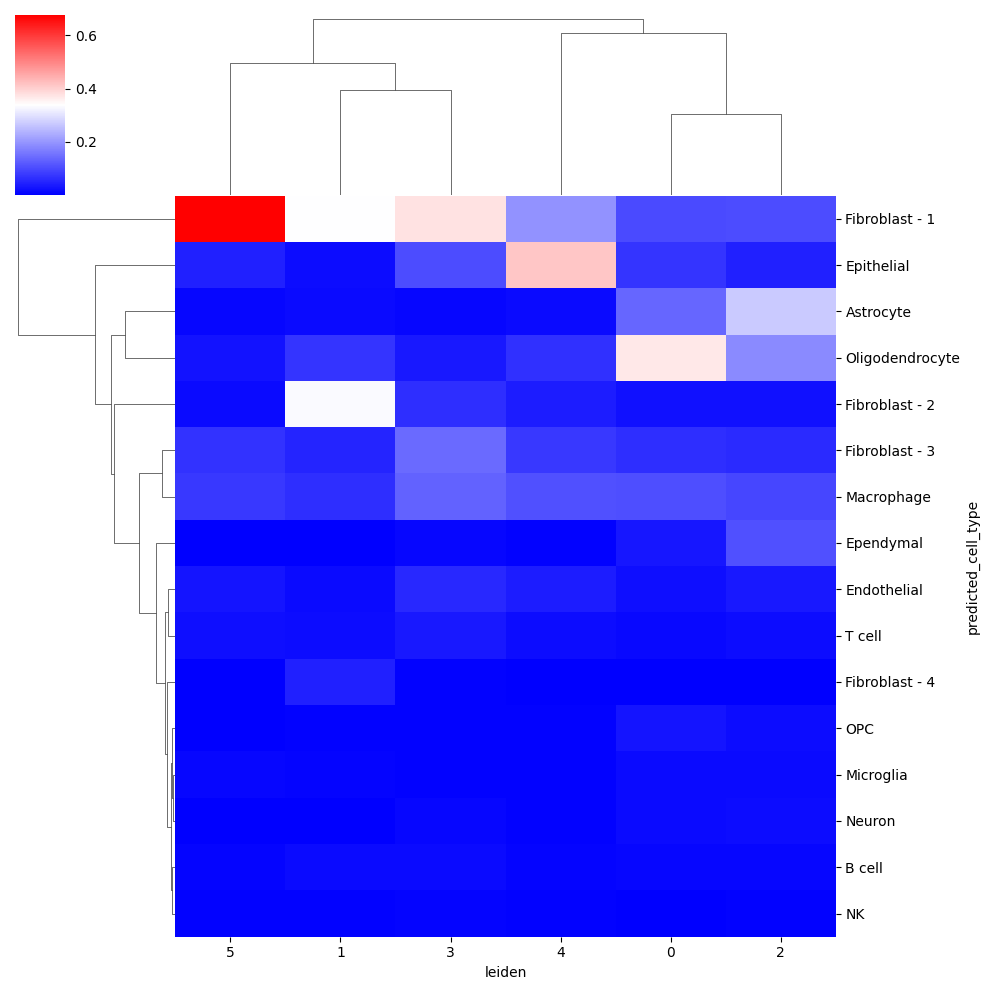

In [38]:
import seaborn as sns
counts = xenium_folder_1.obs.pivot_table(
    index="predicted_cell_type",
    columns="leiden",
    aggfunc="size"
)

counts = counts

sns.clustermap(counts/counts.sum(), cmap="bwr")

In [ ]:
import seaborn as sns
counts = xenium_folder_1.obs.pivot_table(
    index="predicted_cell_type",
    columns="leiden",
    aggfunc="size"
)

sns.clustermap(counts.div(counts.sum(axis=1), axis=0), cmap="Reds")

In [36]:
xenium_folder_1.write_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/data/processed/8_spatial_niches.h5ad")

# Comparison of stuff

In [2]:
import scanpy as sc
adata = sc.read_h5ad("/oak/stanford/projects/kibr/Reorganizing/Projects/James/choroid-plexus-cell-atlas/data/processed/8_spatial_niches.h5ad")

In [ ]:
import seaborn as sns

cell_type = "Fibroblast - 1"

model = sklearn.linear_model.SGDClassifier(n_jobs=-1)
model.fit(adata[adata.obs["cell_type"].eq(cell_type)].X, adata[adata.obs["cell_type"].eq(cell_type)].obs["leiden"])
logistic_regression_results = pd.DataFrame(model.coef_, index=model.classes_, columns=adata.var.index).T
sns.clustermap(logistic_regression_results[[x > 0.5 for x in adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0).reshape(-1).flatten().tolist()[0]]], cmap="bwr")

In [ ]:
logistic_regression_results_macrophage = logistic_regression_results

In [ ]:
import matplotlib.pyplot as plt
adata.obs["cell_type"] = adata.obs["predicted_cell_type"].replace({
    "Inhibitory Neuron": "Neuron",
    "Interneuron": "Neuron",
    "Neural": "Neuron",
    "Astro": "Astrocyte",
    "Fib-1": "Fibroblast - 1",
    "Fib-2": "Fibroblast - 2",
    "Fib-3": "Fibroblast - 3",
    "Fib-4": "Fibroblast - 4",
    "Oligo": "Oligodendrocyte",
})


counts = adata.obs.pivot_table(index="leiden", columns="cell_type", aggfunc="size")
(counts.T/counts.sum(axis=1)).T.plot.bar(stacked=True, cmap="tab20")
plt.legend(bbox_to_anchor=(1.05, 1))

In [69]:
adata.write_h5ad("niches.h5ad")

In [ ]:
sc.pl.dotplot(adata, var_names=["CLDN11", "IGFBP5", "CDH1"], groupby="predicted_cell_type")

In [ ]:
ax = adata[adata.obs["predicted_cell_type"].str.contains("Fibroblast - 4")].obs \
    .plot.scatter(
        x="x_centroid", 
        y="y_centroid", 
        c="predicted_cell_type", #adata[:, "CDH1"].X[:, 0].todense().flatten().tolist()[0]
        figsize=(10, 20),
        cmap="tab20",
        s=1
    )

plt.title("Fibroblast Subtypes")

# Sugar
ax.xaxis.set_visible(False)  # Hide x-axis
ax.yaxis.set_visible(False)  # Hide y-axis

for spine in ax.spines.values():
    spine.set_visible(False)

In [23]:
import scipy.spatial

ckd_tree = scipy.spatial.cKDTree(adata.obs[["x_centroid", "y_centroid"]])

In [ ]:
from tqdm import tqdm
neighbor_types = {niche: [] for niche in range(6)}
for niche in range(6):
    macrophages = adata.obs[adata.obs["predicted_cell_type"].eq("Macrophage") & adata.obs["leiden"].eq(str(niche))]
    for i, row in tqdm(macrophages.iterrows()):
        # Query nearest neighbors (e.g., 5 nearest excluding the macrophage itself)
        distances, indices = ckd_tree.query([row['x_centroid'], row['y_centroid']], k=6)
        # Get cell types of nearest neighbors, excluding the macrophage itself (slicing [1:])
        neighbors = adata.obs.iloc[indices[1:]]['predicted_cell_type']
        neighbor_types[niche].extend(neighbors)

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

counts = pd.concat({key: pd.Series(neighbor_types[key]).value_counts() for key in neighbor_types}, axis=1)
(counts / counts.sum(axis=0)).T.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1))

In [117]:
adata.obs["predicted_cell_type"] = adata.obs["predicted_cell_type"].replace({
    "Inhibitory Neuron": "Neuron",
    "Interneuron": "Neuron",
    "Neural": "Neuron",
    "Astro": "Astrocyte",
    "Fib-1": "Fibroblast - 1",
    "Fib-2": "Fibroblast - 2",
    "Fib-3": "Fibroblast - 3",
    "Fib-4": "Fibroblast - 4",
    "Oligo": "Oligodendrocyte",
})

In [ ]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 20), sharey=True)
for column in (counts / counts.sum(axis=0)).columns:
    i = int(column)
    ((counts / counts.sum(axis=0))[column] / niche_counts[str(column)])[(counts / counts.sum(axis=0))[column] > 0.01].sort_values(ascending=False).plot.bar(ax = ax[i//3][i%3])
    ax[i//3][i%3].axhline(1, c="r", linestyle="--")
    ax[i//3][i%3].set_title(i)


In [ ]:
(counts / counts.sum(axis=0))

In [ ]:
niche_counts = adata.obs.pivot_table(index="predicted_cell_type", columns="leiden", aggfunc="size") / adata.obs.pivot_table(index="predicted_cell_type", columns="leiden", aggfunc="size").sum()

In [ ]:
(counts / counts.sum(axis=0))[0] / niche_counts[str(0)]

In [ ]:
(counts / counts.sum(axis=0))[0]

# Microglia

In [ ]:
from tqdm import tqdm
neighbor_types = {niche: [] for niche in range(6)}
for niche in range(6):
    macrophages = adata.obs[adata.obs["predicted_cell_type"].eq("Microglia") & adata.obs["leiden"].eq(str(niche))]
    for i, row in tqdm(macrophages.iterrows()):
        # Query nearest neighbors (e.g., 5 nearest excluding the macrophage itself)
        distances, indices = ckd_tree.query([row['x_centroid'], row['y_centroid']], k=6)
        # Get cell types of nearest neighbors, excluding the macrophage itself (slicing [1:])
        neighbors = adata.obs.iloc[indices[1:]]['predicted_cell_type']
        neighbor_types[niche].extend(neighbors)

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

counts = pd.concat({key: pd.Series(neighbor_types[key]).value_counts() for key in neighbor_types}, axis=1)
(counts / counts.sum(axis=0)).T.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
adata.obs["predicted_cell_type"] = adata.obs["predicted_cell_type"].replace({
    "Inhibitory Neuron": "Neuron",
    "Interneuron": "Neuron",
    "Neural": "Neuron",
    "Astro": "Astrocyte",
    "Fib-1": "Fibroblast - 1",
    "Fib-2": "Fibroblast - 2",
    "Fib-3": "Fibroblast - 3",
    "Fib-4": "Fibroblast - 4",
    "Oligo": "Oligodendrocyte",
})

In [ ]:
f, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 20))
for column in (counts / counts.sum(axis=0)).columns:
    i = int(column)
    ((counts / counts.sum(axis=0))[column] / niche_counts[str(column)]).sort_values(ascending=False).plot.bar(ax = ax[i//3][i%3])
    ax[i//3][i%3].axhline(1, c="r", linestyle="--")
    ax[i//3][i%3].set_title(i)

